In [41]:
!7za x data.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 622499202 bytes (594 MiB)

Extracting archive: data.zip
 27% 4096 Open              
ERRORS:
Unexpected end of archive

--
Path = data.zip
Type = zip
ERRORS:
Unexpected end of archive
Physical Size = 622499202

  1%    ERROR: Data Error : data_for_achive/test/pictures/test_0257.png
100% 53 - data_for_achive/test/pictures/test_0257.png                                                     
Sub items Errors: 1

Archives with Errors: 1

Open Errors: 1

Sub items Errors: 1


In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd

from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image

In [2]:
batch_size = 512
lerning_rate = 0.001
epoch = 8

In [193]:
sanders_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = ImageFolder("/content/data_for_achive/train/images", sanders_transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)

table = pd.read_csv("/content/data_for_achive/train/answers.csv")

In [3]:
def split_array(array, batch_size):
    out_array = []
    counter = 0
    crnt_id = 0

    out_array.append([])

    for element in array:
        out_array[crnt_id].append(element)
        counter += 1

        if counter == batch_size:
            crnt_id += 1
            counter = 0
            out_array.append([])

            continue

    return out_array

In [195]:
labels = split_array(table['count'], batch_size)
labels = [torch.Tensor(list(element)).to(torch.long) for element in labels]

In [196]:
class BurgerNet(nn.Module):
    def __init__(self):
         super(BurgerNet, self).__init__()
         self.layer1 = nn.Sequential( nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
         self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
         self.drop_out = nn.Dropout()
         self.fc1 = nn.Linear(7 * 7 * 64, 1000)
         self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out.view(out.size(0), -1)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)

      return out

model = BurgerNet()
criterion = nn.CrossEntropyLoss()
mac_optimizer = torch.optim.Adam(model.parameters(), lr=lerning_rate)

In [ ]:
loss_list = []
acc_list = []

for epoch_num in range(epoch):
  for i, (images, _) in enumerate(tqdm.tqdm(data_loader)):
    outputs = model(images)

    loss = criterion(outputs, labels[i])
    loss_list.append(loss.item())

    mac_optimizer.zero_grad()
    loss.backward()
    mac_optimizer.step()

    total = labels[i].size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels[i]).sum().item()
    acc_list.append(correct / total)

torch.save(model, "model.pt")

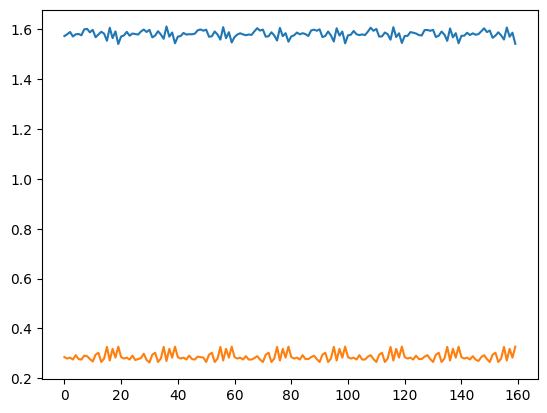

In [202]:
plt.plot(loss_list)
plt.plot(acc_list)

plt.show()

In [285]:
def predict(path):
    def predict_inner(path):
        image = Image.open(path).convert("RGB")
        image = sanders_transform(image)
        image = image[None, :, :, :]

        out = model(image)

        return (out.abs().sum() / out.size()[1]).item()

    array = [predict_inner(path) for _ in range(10)]

    return round(sum(array) / len(array))

predict("/content/hor.jpg")

3

In [ ]:
data = pd.read_csv("/content/data_for_achive/test/image_names.csv")
output = [predict(f"/content/data_for_achive/test/pictures/{name}") for name in tqdm.tqdm(data['name'])]

pd.DataFrame({"count": output}).to_csv("/content/data.csv")